In [1]:
import sys
from ssd import SSD
import os
import torch

voc_classes = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

ssd_cfg = {
    'classes_num': 21,
    'input_size': 300,
    'dbox_num': [4, 6, 6, 6, 4, 4],
    'feature_maps': [38, 19, 10, 5, 3, 1],
    'steps': [8, 16, 32, 64, 100, 300],
    'min_sizes': [30, 60, 111, 162, 213, 264],
    'max_sizes': [60, 111, 162, 213, 264, 315],
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

net = SSD(phase='test', cfg=ssd_cfg)
weight_pth = './weights/ssd_weights_2/ssd_weights_100.pth'
net_weights = torch.load(weight_pth, map_location={'cuda:0': 'cpu'})
net.load_state_dict(net_weights)
print('Preparation is finished!')

Preparation is finished!


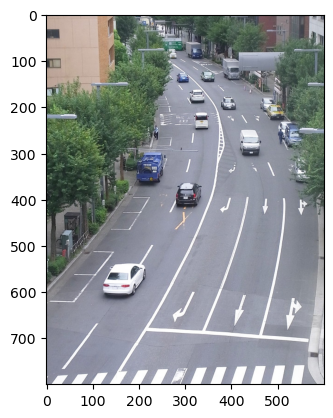

torch.Size([1, 21, 200, 5])
tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0738,  0.1109,  0.3226,  0.9664,  0.7252],
          [ 0.0551,  0.4007,  0.4669,  0.9857,  0.7125],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0327,  0.9164, -0.0713,  1.1015,  0.0767],
          [ 0.0237,  0.4915,  0.7808,  1.0709,  0.9929],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [

c:\Users\ShimaSef\object_detection\ssd.py:315: UserWarning: An output with one or more elements was resized since it had shape [199], which does not match the required output shape [26]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Resize.cpp:33.)
  torch.index_select(x1, 0, idx, out=tmp_x1)
c:\Users\ShimaSef\object_detection\ssd.py:316: UserWarning: An output with one or more elements was resized since it had shape [199], which does not match the required output shape [26]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at C:\cb\pytorch_1

In [2]:
import cv2
from voc import DataTransform
import matplotlib.pyplot as plt
%matplotlib inline

image_file_path = './data/road_tokyo.jpg'
img = cv2.imread(image_file_path)
height, width, channels = img.shape
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
color_mean = (104, 117, 123)
input_size = 300
transform = DataTransform(input_size, color_mean)

phase = 'val'
img_transformed, boxes, labels = transform(
  img,
  phase,
  '',
  ''
)
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

net.eval()
x = img.unsqueeze(0)
detections = net(x)
print(detections.shape)
print(detections)

In [3]:
import numpy as np

class SSDPredictions():
  def __init__(self, eval_categories, net):
    self.eval_categories = eval_categories
    self.net = net
    color_mean = (104, 117, 123)
    input_size = 300
    self.transform = DataTransform(input_size, color_mean)
  
  def ssd_predict(self, image_file_path, confidence_threshold=0.5):
    img = cv2.imread(image_file_path)
    height, width, channels = img.shape
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    phase = 'val'
    img_transformed, boxes, labels = self.transform(
      img,
      phase,
      '',
      ''
    )
    img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

    self.net.eval()
    x = img.unsqueeze(0)
    detections = self.net(x)
    
    predict_bbox = []
    pre_dict_label_index = []
    scores = []
    detections = detections.cpu().detach().numpy()
    
    find_index = np.where(detections[:, 0:, :, 0] >= confidence_threshold)
    detections = detections[find_index]
    
    for i in range(len(find_index[1])):
      if (find_index[1][i]) > 0:
        sc = detections[i][0]
        bbox = detections[i][1:] * [width, height, width, height]
        label_ind = find_index[1][i]-1
        predict_bbox.append(bbox)
        pre_dict_label_index.append(label_ind)
        scores.append(sc)
    
    return rgb_img, predict_bbox, pre_dict_label_index, scores
  
  
  def draw(self, rgb_img, bbox, label_index, scores, label_names):
  
   
  def show(self, image_file_path, confidence_threshold):
    rgb_img, predict_bbox, pre_dict_label_index, scores = self.ssd_predict(image_file_path, confidence_threshold)
    self.draw(
      rgb_img,
      bbox=predict_bbox,
      labels_index=pre_dict_label_index,
      scores=scores,
      label_names=self.eval_categories
    )